c:\Users\Eduardo Angelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Eduardo Angelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
train Loss: 0.6892 Acc: 0.5571
val Loss: 0.6447 Acc: 0.5556
Epoch 2/50
----------


c:\Users\Eduardo Angelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 0.5256 Acc: 0.7571
val Loss: 0.5284 Acc: 0.7778
Epoch 3/50
----------
train Loss: 0.4997 Acc: 0.8286
val Loss: 0.4283 Acc: 1.0000
Epoch 4/50
----------
train Loss: 0.4000 Acc: 0.8571
val Loss: 0.3861 Acc: 0.8889
Epoch 5/50
----------
train Loss: 0.3417 Acc: 0.9143
val Loss: 0.3465 Acc: 0.8889
Epoch 6/50
----------
train Loss: 0.3497 Acc: 0.8571
val Loss: 0.2789 Acc: 1.0000
Epoch 7/50
----------
train Loss: 0.2652 Acc: 0.9143
val Loss: 0.2162 Acc: 1.0000
Epoch 8/50
----------
train Loss: 0.2078 Acc: 0.9571
val Loss: 0.1760 Acc: 1.0000
Epoch 9/50
----------
train Loss: 0.1904 Acc: 0.9571
val Loss: 0.1447 Acc: 1.0000
Epoch 10/50
----------
train Loss: 0.2518 Acc: 0.9000
val Loss: 0.1276 Acc: 1.0000
Epoch 11/50
----------
train Loss: 0.3733 Acc: 0.8429
val Loss: 0.1251 Acc: 1.0000
Epoch 12/50
----------
train Loss: 0.1506 Acc: 0.9429
val Loss: 0.1493 Acc: 1.0000
Epoch 13/50
----------
train Loss: 0.1917 Acc: 0.9429
val Loss: 0.1898 Acc: 1.0000
Early stopping
Accuracy: 1.0000
Pr

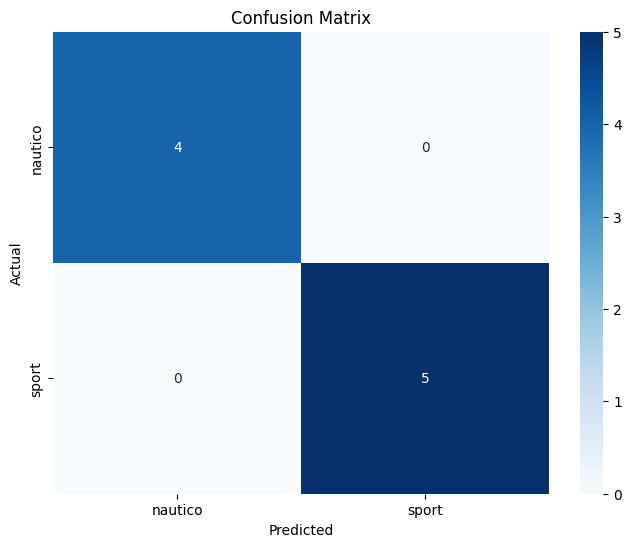

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy

# Definir transformações para os dados de treinamento e validação
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'imagens'
batch_size = 32
num_epochs = 50
patience = 10

# Carregar os dados
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Carregar o modelo EfficientNet pré-treinado
model_ft = models.efficientnet_b0(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1)
)

# Descongelar mais camadas
for param in list(model_ft.parameters())[:-10]:
    param.requires_grad = False

model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss()

# Usar AdamW com weight decay
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, weight_decay=1e-4)

# Usar Cosine Annealing LR Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Função para treinar o modelo com early stopping
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs).round()
                    loss = criterion(outputs, labels.unsqueeze(1))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.unsqueeze(1).data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Salvar o modelo se a acurácia na validação melhorar
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(model_ft, criterion, optimizer, scheduler, num_epochs=num_epochs, patience=patience)

# Salvando o modelo treinado
torch.save(model_ft.state_dict(), 'modelo_camisas_sport_nautico.pth')
torch.save(optimizer.state_dict(), 'optimizer_camisas_sport_nautico.pth')

# Função para calcular e exibir métricas de avaliação
def evaluate_model(model, dataloaders, dataset_sizes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot da matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Avaliar o modelo treinado
evaluate_model(model_ft, dataloaders, dataset_sizes)